# Set for jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Env

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

In [5]:
from modules.dataset import get_loader
from modules.utils import imsshow, imgshow
from modules.solver import Lab2Solver

In [14]:
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data process

In [6]:
BG = [0]
RV = [85]
MYO = [170]
LV = [255]

train_loader = get_loader(image_root_path='./ACDC-2D-All/train/',palette=[RV,MYO,LV], batch_size=32, mode='train')
val_loader = get_loader(image_root_path='./ACDC-2D-All/val/', palette=[RV,MYO,LV], batch_size=32, mode='val')
test_loader = get_loader(image_root_path='./ACDC-2D-All/test/',palette=[RV,MYO,LV], batch_size=32, mode='test')

image count in train path :1394
image count in val path :200
image count in test path :204


torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


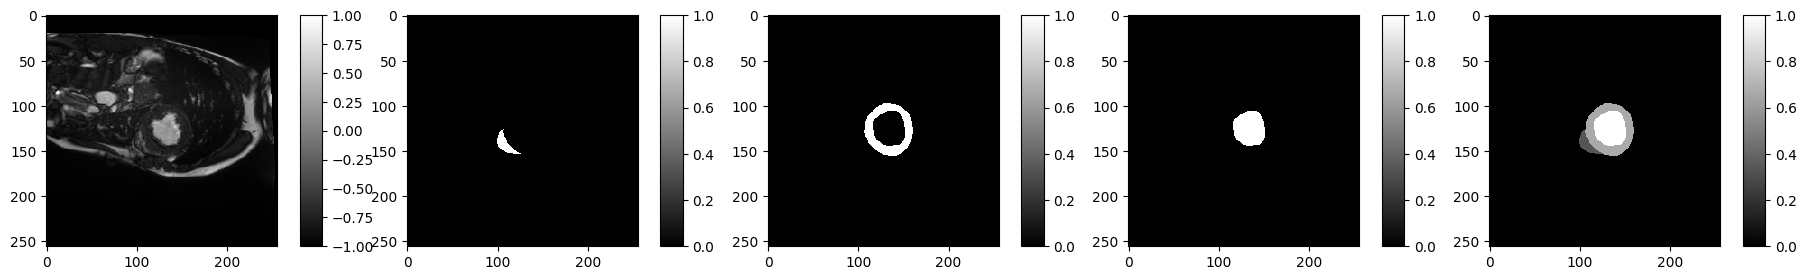

Number of 0.0 in the array: 62836
Number of 0.3333333432674408 in the array: 262
Number of 0.6666666865348816 in the array: 1310
Number of 1.0 in the array: 1128


In [6]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 10
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])


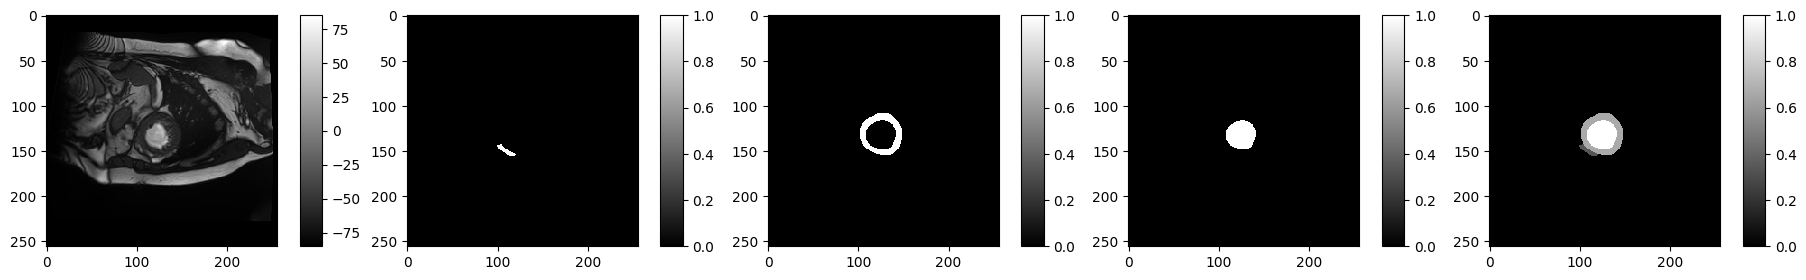

Number of 0.0 in the array: 63730
Number of 0.3333333432674408 in the array: 96
Number of 0.6666666865348816 in the array: 865
Number of 1.0 in the array: 845


In [7]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(val_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 5
all_gt = (seg_gt[idx,0, :, :] * 85 + seg_gt[idx,1, :, :] * 170 + seg_gt[idx,2, :, :] * 255)/255
imsshow([image[idx, 0, :, :]* 85, seg_gt[idx, 0, :, :],seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :], all_gt], is_colorbar=True, is_ticks=True)

# for testing
# imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)

target = all_gt
unique, count = np.unique(target, return_counts=True)

# Print the results
for u, c in zip(unique, count):
    print("Number of {} in the array: {}".format(u, c))

# Network and Solver

In [49]:
from modules.network_without_shortcut import UNet
from modules.loss import MyBinaryCrossEntropy

In [48]:
is_load = False
checkpoint = "checkpoint/04-06_19-24-59-v1.1-20+20+20epoch.pth"

get_graph = False
log_dir = "log/04-08_13-15-51_v1.0_60epoch"

net = UNet(n_channels=1, n_classes=3, C_base=32)
if is_load:
    net.load_state_dict(torch.load(checkpoint))

if get_graph:
    dummy_input = torch.rand(32, 1, 256, 256)
    with SummaryWriter(log_dir, comment="unet with shortcut") as w:
        w.add_graph(net, (dummy_input,))

In [51]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = Lab2Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler,
    device="cuda:2"
)

# Train

  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

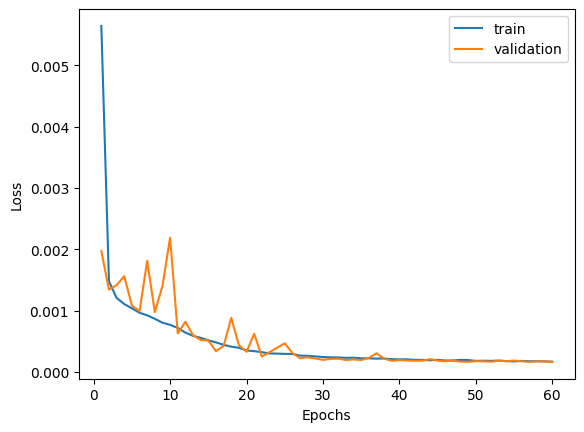

In [52]:
solver.train(
    epochs=60,
    data_loader=train_loader,
    val_loader=val_loader,
    log=False
)

In [ ]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
print(seg_gt.dtype)

torch.Size([32, 1, 256, 256])
torch.Size([32, 3, 256, 256])
torch.float32


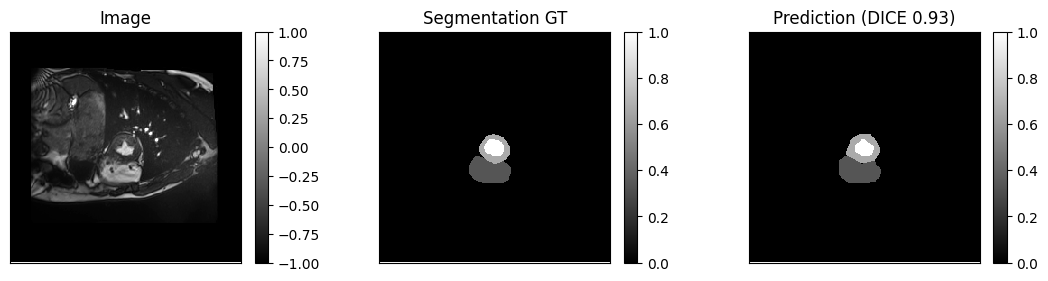

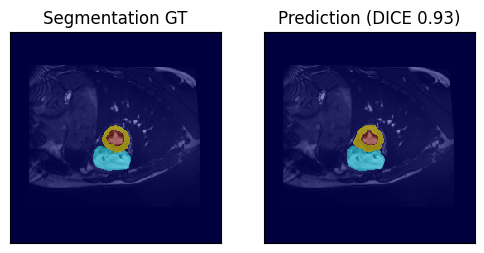

In [61]:
solver.visualize(test_loader, 11)

In [ ]:
solver.validate(
    data_loader=test_loader
)

# Save checkpoint

In [57]:
import time
timestamp = time.strftime("%m-%d_%H-%M-%S", time.localtime())

In [58]:
name = "test_without_shourtcut-60epoch"
torch.save(net.state_dict(), f'./checkpoint/{timestamp}-{name}.pth')

# Test

#### load checkpoint

In [8]:
from modules.network import UNet
import torch

is_load = True
checkpoint = "checkpoint/04-08_14-00-36-v1.0-60epoch.pth"

net = UNet(n_channels=1, n_classes=3, C_base=32)
if is_load == True:
    net.load_state_dict(torch.load(checkpoint))
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
net = net.to(device)
net.eval()

UNet(
  (in_conv): DoubleConv(
    (layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (layers): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (

#### calculate Dice

In [9]:
import time
import imageio
import itertools
import numpy as np
from modules.evaluation import get_DC, get_DC_square
from modules.utils import imgshow, imsshow, image_mask_overlay, onehot_to_mask


dice = []
dice_square = []
for batch_num in range(7):
    print(batch_num, end=' ')
    img, gt = next(itertools.islice(test_loader, batch_num, None))
    img = img.to(device)
    gt = gt.to(device)
    result = net(img)
    pred_seg_probs = torch.sigmoid(result)
    DC_ALL = get_DC(pred_seg_probs, gt)
    DC_RV = get_DC(pred_seg_probs[:,0,:,:], gt[:,0,:,:])
    DC_MYO = get_DC(pred_seg_probs[:,1,:,:], gt[:,1,:,:])
    DC_LV = get_DC(pred_seg_probs[:,2,:,:], gt[:,2,:,:])
    dice.append([DC_ALL, DC_RV, DC_MYO, DC_LV])
#         output = (x_und[idx] * 255).astype('uint8')
#         imageio.mimsave(f'./gif_und/animation_{batch_num}_{idx}_{PSNR[-1]:.2f}.gif', output, fps=10)
print()
tag = ["All", "RV", "MYO", "LV"]
for i in range(4):
    dice_arr = np.array([dice[i]])
    print(f"[avg_{tag[i]}_DiceCoefficient]: {np.mean(dice_arr)}")
    print(f"[var_{tag[i]}_DiceCoefficient]: {np.var(dice_arr)}")

0 1 2 3 4 5 6 
[avg_All_DiceCoefficient]: 0.9161366379899551
[var_All_DiceCoefficient]: 0.0008580568703768968
[avg_RV_DiceCoefficient]: 0.8972847119602236
[var_RV_DiceCoefficient]: 0.0009651639745845269
[avg_MYO_DiceCoefficient]: 0.9080136927009786
[var_MYO_DiceCoefficient]: 0.001378413116541546
[avg_LV_DiceCoefficient]: 0.9147069035101842
[var_LV_DiceCoefficient]: 0.0006630865334700514


#### Show Image

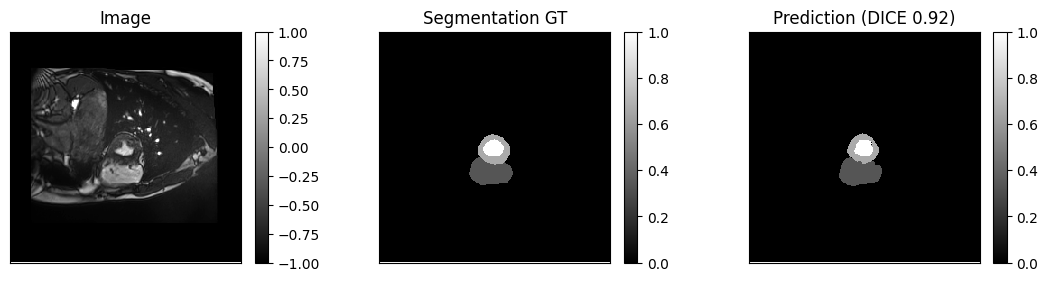

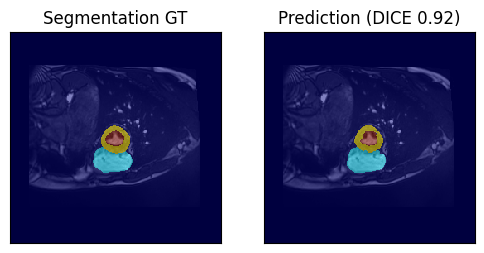

In [16]:
def visualize(model, data_loader, idx, device, *, dpi=100):
    with torch.no_grad():
        # fetch data batch
        if idx < 0 or idx > len(data_loader) * data_loader.batch_size:
            raise RuntimeError("idx is out of range.")

        batch_idx = idx // data_loader.batch_size
        batch_offset = idx - batch_idx * data_loader.batch_size

        batch = next(itertools.islice(data_loader, batch_idx, None))

        # inference
        image, seg_gt = batch

        image = image.to(device)  # [B, C=1, H, W]
        seg_gt = seg_gt.to(device)
        B, C, H, W = image.shape

        # Get the mask
        model.eval()
        pred_seg = model(image)  # [B, C=1, H, W]
        pred_seg_probs = torch.sigmoid(pred_seg)
        pred_seg_mask = pred_seg_probs > 0.5  # default threshoulding: 0.5

        #get DC
        DC = get_DC(pred_seg_mask[batch_offset, ...]
                        [None, ...], seg_gt[batch_offset, ...][None, ...])
        # partition ground truth
        seg_gt_RV = seg_gt[batch_offset, 0, :, :].detach().cpu().numpy()
        seg_gt_MYO = seg_gt[batch_offset, 1, :, :].detach().cpu().numpy()
        seg_gt_LV = seg_gt[batch_offset, 2, :, :].detach().cpu().numpy()

        # partition mask
        pred_seg_mask_RV = pred_seg_mask[batch_offset, 0, :, :].detach().cpu().numpy()
        pred_seg_mask_MYO = pred_seg_mask[batch_offset, 1, :, :].detach().cpu().numpy()
        pred_seg_mask_LV = pred_seg_mask[batch_offset, 2, :, :].detach().cpu().numpy()
        image = image[batch_offset,0,:,:].detach().cpu().numpy()


        seg_gt = (seg_gt_RV * 85 + seg_gt_MYO * 170 + seg_gt_LV * 255)/255
        # # max_values = np.maximum.reduce([pred_seg_mask_RV, pred_seg_mask_MYO, pred_seg_mask_LV])
        result = np.zeros((256, 256))

        pal = [85, 170, 255]
        for i in range(256):
            for j in range(256):
                value = np.array(
                    [pred_seg_mask_RV[i, j], pred_seg_mask_MYO[i, j], pred_seg_mask_LV[i, j]])
                result[i, j] = pal[np.argmax(
                    value)] * value[np.argmax(value)]
        pred_seg_mask = result/255

        seg_gt_overlay = image_mask_overlay(image, seg_gt)
        pred_overlay = image_mask_overlay(image, pred_seg_mask)

        imsshow([image, seg_gt, pred_seg_mask],
                titles=['Image',
                        f"Segmentation GT",
                        f"Prediction (DICE {DC:.2f})"],
                num_col=3,
                dpi=dpi,
                cmap= "gray",
                is_colorbar=True)
        imsshow([seg_gt_overlay, pred_overlay],
                titles=[f"Segmentation GT",
                        f"Prediction (DICE {DC:.2f})"],
                num_col=2,
                dpi=dpi,
                is_colorbar=False)

visualize(net, test_loader, 10, device=device)